In [157]:
import pandas as pd
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [158]:
#Data Preprocessing and Feature Engineering
from textblob import TextBlob
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [159]:
#Model Selection and Validation
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score

In [160]:
dataset = pd.read_csv("./Dataset/X_train_y_train.csv", sep=";")
dataset_test = pd.read_csv("./Dataset/X_test.csv", sep=";")

X_train = dataset["Caption"]
categories = dataset[["Id", "category_1", "category_2", "category_3", "category_4"]]

# output corresponding to the category 1 (does the answer belongs to cat 1)
y_train1 = dataset["category_1"]
y_train2 = dataset["category_2"]
y_train3 = dataset["category_3"]
y_train4 = dataset["category_4"]


In [161]:
print(f"Fraction of 1 in category 1: {sum(y_train1) / y_train1.shape[0]}")
print(f"Fraction of 1 in category 2: {sum(y_train2) / y_train2.shape[0]}")
print(f"Fraction of 1 in category 3: {sum(y_train3) / y_train3.shape[0]}")
print(f"Fraction of 1 in category 4: {sum(y_train4) / y_train4.shape[0]}")

Fraction of 1 in category 1: 0.27835051546391754
Fraction of 1 in category 2: 0.354639175257732
Fraction of 1 in category 3: 0.488659793814433
Fraction of 1 in category 4: 0.11752577319587629


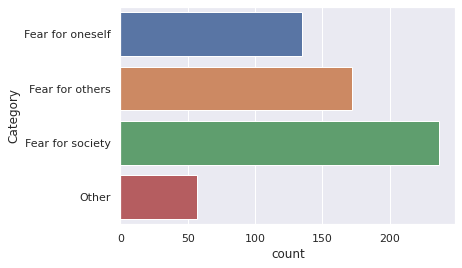

In [162]:
categories.rename(
    columns={
        "category_1": "Fear for oneself",
        "category_2": "Fear for others",
        "category_3": "Fear for society",
        "category_4": "Other"
    },
    inplace=True,
)

df = pd.melt(
    categories,
    id_vars=["Id"],
    value_vars=["Fear for oneself", "Fear for others", "Fear for society", "Other"],
    var_name="Category",
)
df = df[df["value"] == 1]

g = sns.set_theme(style="darkgrid")
sns.countplot(data=df, y="Category")
plt.show()

In [163]:
def form_sentence(text):
    blob = TextBlob(text)
    return ' '.join(blob.words)

print(form_sentence(dataset['Caption'].iloc[10]))
print(dataset['Caption'].iloc[10])

la reprise en plusieurs étapes de la pandémie la crise économique et sociale en particulier chez les plus d munis
la reprise en plusieurs étapes de la pandémie
 la crise économique et sociale, en particulier chez les plus d&munis


In [164]:
def no_user_alpha(text):
    text_list = [ele for ele in text.split() if ele != 'user']
    clean_tokens = [t for t in text_list if re.match(r'[^\W\d]*$', t)]
    clean_s = ' '.join(clean_tokens)
    clean_mess = [word for word in clean_s.split() if word.lower() not in stopwords.words('french')]
    return clean_mess
print(no_user_alpha(form_sentence(dataset['Caption'].iloc[10])))
print(dataset['Caption'].iloc[10])

['reprise', 'plusieurs', 'étapes', 'pandémie', 'crise', 'économique', 'sociale', 'particulier', 'chez', 'plus', 'munis']
la reprise en plusieurs étapes de la pandémie
 la crise économique et sociale, en particulier chez les plus d&munis


In [165]:
def normalization(text_list):
        lem = WordNetLemmatizer()
        normalized_caption = []
        for word in text_list:
            normalized_text = lem.lemmatize(word,'v')
            normalized_caption.append(normalized_text)
        return normalized_caption


In [166]:
def text_processing(text):
    return normalization(no_user_alpha(form_sentence(text)))

In [167]:
def predict_for_cat(category):
    msg_train, msg_test, label_train, label_test = train_test_split(dataset['Caption'], dataset[category], test_size=0)
    pipeline = Pipeline([
        ('bow',CountVectorizer(analyzer=text_processing)),  # strings to token integer counts
        ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
        ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
    ])
    pipeline.fit(msg_train,label_train)
    predictions = pipeline.predict(msg_test)
    print(classification_report(predictions,label_test))
    print(confusion_matrix(predictions,label_test))
    print(accuracy_score(predictions,label_test))
    return pipeline

In [168]:
msg_test = dataset_test['Caption'].squeeze()
indexes = dataset_test['Id'].squeeze()

In [169]:
model1 = predict_for_cat('category_1')
model2 = predict_for_cat('category_2')
model3 = predict_for_cat('category_3')
model4 = predict_for_cat('category_4')

predict1 = model1.predict(msg_test)
predict2 = model2.predict(msg_test)
predict3 = model3.predict(msg_test)
predict4 = model4.predict(msg_test)

              precision    recall  f1-score   support

           0       1.00      0.82      0.90        92
           1       0.23      1.00      0.37         5

    accuracy                           0.82        97
   macro avg       0.61      0.91      0.63        97
weighted avg       0.96      0.82      0.87        97

[[75 17]
 [ 0  5]]
0.8247422680412371
              precision    recall  f1-score   support

           0       0.96      0.81      0.88        79
           1       0.50      0.83      0.62        18

    accuracy                           0.81        97
   macro avg       0.73      0.82      0.75        97
weighted avg       0.87      0.81      0.83        97

[[64 15]
 [ 3 15]]
0.8144329896907216
              precision    recall  f1-score   support

           0       0.95      0.57      0.71        61
           1       0.57      0.94      0.71        36

    accuracy                           0.71        97
   macro avg       0.76      0.76      0.71        9

In [170]:
with open('submission.csv','w') as f:
    f.write('Id,category_1,category_2,category_3,category_4\n')
    for i in range(len(predict1)):
        f.write(f"{indexes[i]},{predict1[i]},{predict2[i]},{predict3[i]},{predict4[i]}\n")